# COM2004/3004 - Lab Class 6

## 2 Feature Selection Challenge!

### 2.1 Objective

You will be using data from a character recognition task where each character is represented by
900 pixels.

The objective is to find a subset of 10 pixels that provide a good classification score. This will be
done by using feature selection ideas. Some tools have been provided. This notebook will lead you
through the initial steps to get you started.

### 2.2 Background

One drawback of the nearest-neighbour classifier is that it has to store the complete training set
in memory. This can be a problem if the feature vectors are large and memory is in short supply
(e.g., in embedded systems). A further problem is that computing distances between large feature
vectors can be computationally costly. It is therefore desirable to reduce the size of the feature
vector. In this notebook we are going to use feature selection to reduce the size of the feature vector
from 900 to just 10 (i.e., 90 times less memory, 90 times less computation). It is important that
we choose the 10 features carefully so that we do not lose too much classification performance.

### 2.3 1. Overview of key functions

The notebook will use three main functions. Code for these functions is included in the notebook.
• classify – a nearest neighbour classifier
• divergence – for measuring 1-D divergence
• multidivergence – for measuring multi-dimensional divergence

### 2.4 2. Loading the data

The data for the lab class is a set of images of characters. Each image is a square of 30 by 30
pixels, i.e., 900 pixels in total. The images can therefore be presented by 900 pixel values stored in
a vector.

The data for the lab have been stored as entries in a Python dictionary which has been saved in a
Python ‘pickle’ file. The dictionary contains separate entries for a predified training set, a test set,
training set labels and test set labels. The code in the cell below reads the pickle file and extracts
the data from the dictionary into separate variables.

In [94]:
import pickle
import numpy as np
lab_data = pickle.load(open("data/lab_data_wk6.pkl", "rb"))
train_labels = lab_data["train_labels"]
test_labels = lab_data["test_labels"]
train_data = lab_data["train_data"]
test_data = lab_data["test_data"]

The numpy arrays train_data and test_data contain the character image data. In these arrays,
each row represents one character and contains that character’s 900 pixel values, i.e., the arrays
have 900 columns. There are 699 training characters and 200 for testing.

To display a character as an image we first need to reshape the row of 900 pixel values into a 30
by 30 element matrix. We can do this using numpy’s reshape function. We can then display the
resulting matrix as an image by using matplotlib’s matshow function.

Execute the cell below to display the first character in the training data. Then try editting and
re-excuting the cell to display other characters.

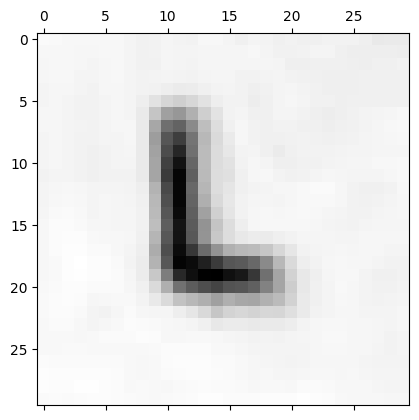

In [95]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
# display the 4th training data sample
letter_image = np.reshape(train_data[3, :], (30, 30), order="F")
plt.matshow(letter_image, cmap=cm.Greys_r)

In the cell below write code to display the first 16 training samples as a grid of 4x4 subplots.

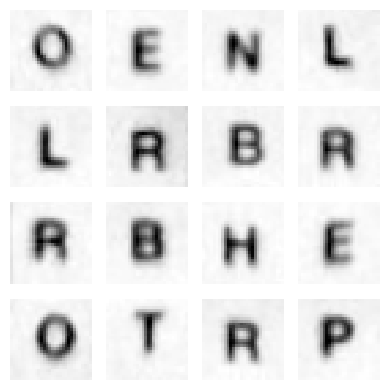

In [96]:
fig, axes = plt.subplots(4, 4, figsize=(4, 4))

for i, ax in enumerate(axes.flat):
    x4_letter_image = np.reshape(train_data[i, :], (30, 30), order="F")
    ax.matshow(x4_letter_image, cmap=cm.Greys_r)
    ax.axis('off')

plt.tight_layout()
plt.show()



The variables called train_labels and test_labels store the character labels. The labels are
represented using integers with 1=A, 2=B, 3=C, etc.

The labels are stored in a numpy array with 1 row and either 699 or 200 columns for the training
and test data respectively. We can print the label for the Nth character in the training set by
typing,

`print(train_labels[0, N - 1])`

So, for example, to display the label of the 10th character, we can use,

In [97]:
print(train_labels[0, 9])

2


Display the 10’th character image to check that it corresponds to the label.

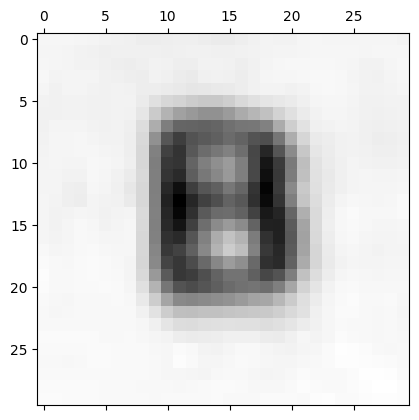

In [98]:
tenth_letter_image = np.reshape(train_data[9, :], (30, 30), order="F")
plt.matshow(tenth_letter_image, cmap=cm.Greys_r)

### 2.5 3. Using the classify function

The cell below provides a function that performs nearest neighbour classification

In [165]:
# def classify(train, train_labels, test, test_labels, features=None):
#     """Nearest neighbour classification.
#     train - data matrix storing training data, one sample per row
#     train_label - a vector storing the training data labels
#     test - data matrix storing the test data
#     test_lables - a vector storing the test data labels for evaluation
#     features - a vector if indices that select the feature to use
#     if features=None then all features are used
#     returns: (score, confusions) - a percentage correct and a
#     confusion matrix
#     """
#     # Use all feature is no feature parameter has been supplied
#     if features is None:
#         features = np.arange(0, train.shape[1])
        
#     # Select the desired features from the training and test data
#     train = train[:, features]
#     test = test[:, features]
    
#     # Super compact implementation of nearest neighbour
#     x = np.dot(test, train.transpose())
#     modtest = np.sqrt(np.sum(test * test, axis=1))
#     modtrain = np.sqrt(np.sum(train * train, axis=1))
#     dist = x / np.outer(modtest, modtrain.transpose())
    
#     # cosine distance
#     nearest = np.argmax(dist, axis=1)
#     mdist = np.max(dist, axis=1)
#     label = train_labels[0, nearest]
#     score = (100.0 * sum(test_labels[0, :] == label)) / label.shape[0]
    
#     # Construct a confusion matrix
#     nclasses = np.max(np.hstack((test_labels, train_labels)))
#     confusions = np.zeros((nclasses, nclasses))
#     for i in range(test_labels.shape[1]):
#         confusions[test_labels[0, i] - 1, label[i] - 1] += 1
    
#     return score, confusions

def classify(train, train_labels, test, test_labels, features=None):
    """Nearest neighbour classification.
    train - data matrix storing training data, one sample per row
    train_label - a vector storing the training data labels
    test - data matrix storing the test data
    test_lables - a vector storing the test data labels for evaluation
    features - a vector if indices that select the feature to use
    if features=None then all features are used
    returns: (score, confusions) - a percentage correct and a
    confusion matrix
    """
    # Use all feature is no feature parameter has been supplied
    if features is None:
        features = np.arange(0, train.shape[1])
        
    # Select the desired features from the training and test data
    train = train[:, features]
    test = test[:, features]
    
    # Super compact implementation of nearest neighbour
    x = np.dot(test, train.transpose())
    modtest = np.sqrt(np.sum(test * test, axis=1))
    modtrain = np.sqrt(np.sum(train * train, axis=1))
    dist = x / np.outer(modtest, modtrain.transpose())
    
    # cosine distance
    nearest = np.argmax(dist, axis=1)
    mdist = np.max(dist, axis=1)
    label = train_labels[0, nearest]
    score = (100.0 * sum(test_labels[0, :] == label)) / label.shape[0]
    
    # Construct a confusion matrix
    nclasses = np.max(np.hstack((test_labels, train_labels)))
    confusions = np.zeros((nclasses, nclasses))
    for i in range(test_labels.shape[1]):
        confusions[test_labels[0, i] - 1, label[i] - 1] += 1
    
    return score, confusions

The code is quite compact and is a little hard to understand. It has been written in a way that
avoids using loops which ensures that it runs as quickly as possible. It is using a cosine distance
rather than the more commonly-employed Euclidean distance. (The cosine distance is based on the angle between a pair of feature vectors rather than the distance between points.)
Try out the code by executing the cell below,

69.0


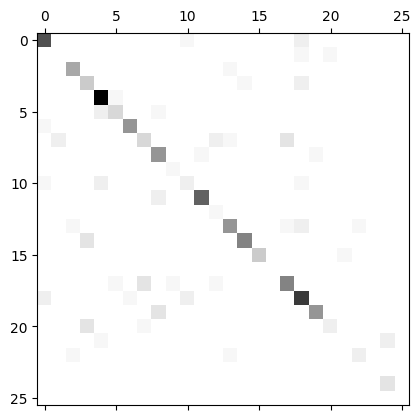

In [170]:
score, confusions = classify(train_data, train_labels, test_data, test_labels,features=reduce_dimensions(train_data))
print(score)
plt.matshow(confusions, cmap=cm.Greys)

In [169]:
def reduce_dimensions(data: np.ndarray) -> np.ndarray:
    data_mean = np.mean(data, axis=0)
    data_centered = data - data_mean

    cov_matrix = np.cov(data_centered.T)

    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    idx = np.argsort(-eigenvalues)
    eigenvectors = eigenvectors[:, idx]

    top_eigenvectors = eigenvectors[:, :10]

    reduced_data = np.dot(data_centered, top_eigenvectors)
    reconstructed_data = np.dot(reduced_data, top_eigenvectors.T)

    # Find the indices of the selected features
    selected_features_idx = np.argsort(np.var(reconstructed_data, axis=0))[::-1][:10]
    
    return selected_features_idx


You should get a score of around 95%. This is a better result than would be achieved by a nearest
neighbour classifier using a Euclidean distance. (Can you think why?)

The classify function can take a 5th argument: a vector of integers representing the indexes of
features to be selected. For example, to test the classifier using just the 50th and 150th pixel in
the image we can use,

`score, confusions = classify(train_data, train_labels, test_data, test_labels, [49, 149])`

Try it out in the cell below. The performance should now be much lower!

COMPETITON:

Your challenge is to find a vector of 10 feature indexes, such that,
classify(train_data, train_labels, test_data, test_labels, features)
returns a result as close to 100% as possible.
After the lab class email me your selection and if you get the best result you may win
a prize!

The rest of the notebook contains some tools and ideas that may help you.

### 2.6 4. Measuring Divergence

The cell below contains a function called divergence that computes the divergence between a pair
of classes for each feature in the feature vector. As input it takes two parameters: the first is a
matrix of data for class 1, and the second is a matrix of data for class 2. The output will be a
vector of divergence scores, i.e., one score for each feature vector element.
Study the code carefully,

In [154]:
def divergence(class1, class2):
    """compute a vector of 1-D divergences
    class1 - data matrix for class 1, each row is a sample
    class2 - data matrix for class 2
    returns: d12 - a vector of 1-D divergence scores
    """
    # Compute the mean and variance of each feature vector element
    m1 = np.mean(class1, axis=0)
    m2 = np.mean(class2, axis=0)
    v1 = np.var(class1, axis=0)
    v2 = np.var(class2, axis=0)
    
    # Plug mean and variances into the formula for 1-D divergence.
    # (Note that / and * are being used to compute multiple 1-D
    # divergences without the need for a loop)
    d12 = 0.5 * (v1 / v2 + v2 / v1 - 2) + 0.5 * (m1 - m2) * (m1 - m2) * (
    1.0 / v1 + 1.0 / v2
    )
    
    return d12

The first couple of lines are computing the means and variances of each of the 900 pixels for each
class. The last line is using the formula for 1-D divergence, but it works on a vector of means and
variances, so it can compute 900 1-D divergences in a single go without needing a loop.
The training data contains many classes (one class for each letter in the alphabet). However,
divergence is measured between just a single pair of classes. So to use the divergence function we
must first select feature vectors from train_data belonging to the pair of classes that we want to
consider. This can be done using the train_label vector. For example, to select all the ‘A’s and
‘B’s run:

In [155]:
adata = train_data[train_labels[0, :] == 1, :]
bdata = train_data[train_labels[0, :] == 2, :]

Now we can measure the 900 separate 1-d divergences between the ‘A’ and ‘B’ class:

In [156]:
d12 = divergence(adata, bdata)
print(d12.shape)
print(d12)

(900,)
[0.27771884 0.39396238 0.38419476 0.34320584 0.3696043  0.3648096
 0.4082894  0.4112968  0.39464986 0.38921964 0.39691216 0.40344337
 0.40146214 0.3709038  0.37457147 0.3574832  0.36386162 0.34519187
 0.34453112 0.38943493 0.4131047  0.44362128 0.45869687 0.4304442
 0.43225464 0.45524675 0.4744264  0.45395553 0.45435217 0.4584308
 0.27247554 0.38974455 0.40015244 0.39104939 0.3913706  0.39638484
 0.43070316 0.41559416 0.3765804  0.36169457 0.37003878 0.37434763
 0.40659934 0.4207787  0.41486526 0.41006938 0.40527546 0.3960733
 0.3865289  0.40571994 0.40066984 0.44177657 0.46114436 0.44142818
 0.45797428 0.49054682 0.50222844 0.4780033  0.4403792  0.45304337
 0.2490616  0.35762948 0.3898954  0.38422382 0.39534113 0.39012462
 0.40832943 0.42746672 0.4085818  0.39003292 0.3803289  0.38845584
 0.43958062 0.47459564 0.449462   0.4153954  0.3862487  0.379359
 0.3745584  0.39815968 0.414103   0.43917775 0.45804572 0.4454354
 0.42577967 0.47043112 0.4994422  0.48585376 0.4573956  0.4765

To see the divergences as an image execute the cell below,

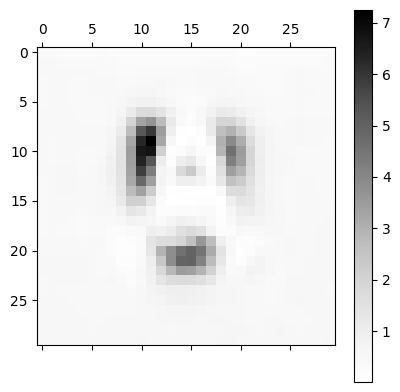

In [157]:
im = plt.matshow(np.reshape(d12, (30, 30), order="F"), cmap=cm.Greys)
# Add a colorbar to show the scale
plt.colorbar(im)

In the above we have considered the divergence between the classes ‘A’ and ‘B’. Use the cell below
to experiment with other character pairs.

### 2.7 5. Feature Selection

Let’s say that we now want to select features that will be good for separating ’A’s and ’B’s. We
need to choose features with high divergence. To do this we will sort the divergence values, d12,
and look at the indexes of the highest values. We can do this with the numpy argsort function,

In [158]:
sorted_indexes = np.argsort(-d12)

(Why are we sorting –d12 and not d12?)

The simplest feature selection algorithm would then just take the 10 features with highest divergences, i.e., the first 10 entries in the indexes vector. Type:

In [159]:
features = sorted_indexes[0:9]
score, confusions = classify(train_data, train_labels, test_data, test_labels,features)
print(score)

38.5


The overall performance might not be very good. Remember the features have only been selected
on the basis of how well they separate ‘A’ and ‘B’. The other 24 letters have not been considered.
To examine the performance of the classifier in more detail we can look at a confusion matrix

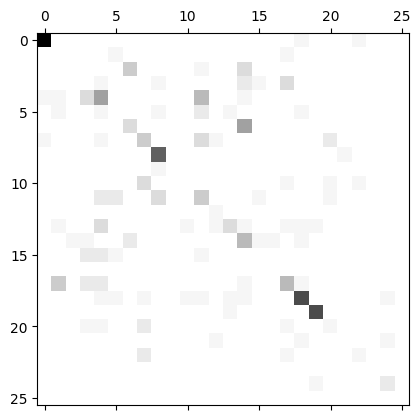

In [160]:
plt.matshow(confusions, cmap=cm.Greys)

If you look at the matrix you should see that not all the A’s and B’s have been correctly classified,
but there are at least no cases of A’s mistaken for B’s or vice versa.

In [161]:
print(confusions[0, 1]) # number of A's mistaken as B's
print(confusions[1, 0]) # number of B's mistaken as A's

0.0
0.0


### 2.8 6. Improving the Feature Selection

**i) Two classes versus many classes**

To get a good overall classification score you need to find a set of features that have high divergence
scores not just with respect to the A and B class, but for every pair of letters. Look again at Section
4 and consider how you might use a nested loop to call divergence repeatedly in such a way that
you compute divergence between every pair of letters.

How might all these pairwise scores be combined to compute some overall divergence score?
Try constructing a multi-class divergence score and using it to select 10 features. Does the overall
recognition score improve?

**ii) Correlation between features**

Remember, when features are correlated, we can not reliably estimate the overall divergence of
a set of features by simply summing the divergences of each individual feature. If features are
correlated then the overall divergence measured with the set of features will be less than the sum
of the divergences measures with individual diveregences.

It turns out that there are indeed strong correlations between some pairs of pixel values. You can
compute the correlation between each pair of features and store the results in a 900 × 900 matrix
using,

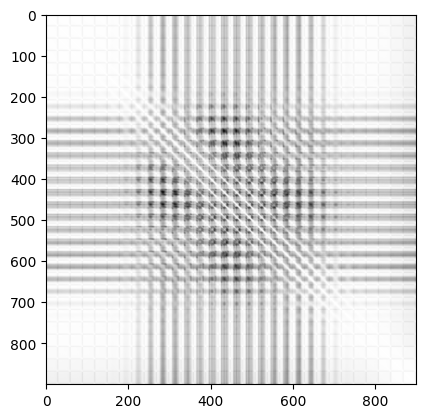

In [162]:
corr = np.corrcoef(train_data, rowvar=0)
plt.imshow(corr, cmap=cm.Greys_r)

(Can you explain the pattern of the corr image?)

So when selecting your 10 features we want to find features for which the divergence is high but
which have low correlation, e.g. compare the correlation between pixels 1 and 2 with the correlation
between pixels 322 and 338, i.e. type,

`print(corr[0, 1])`  
`print(corr[321, 337])`

In the cell below, try implementing an algorithm that iteratively selects features that have a penalised divergence where the penalty is based on degree of correlation to previously selected features.
(A version of this algorithm appears in the lecture notes.)

**iii) Multivariate divergence**

The function multidivergence below computes the divergence using the joint distribution of a set
of features, while assuming that the data is normally distributed.

In [111]:
def multidivergence(class1, class2, features):
    """compute divergence between class1 and class2
    class1 - data matrix for class 1, each row is a sample
    class2 - data matrix for class 2
    features - the subset of features to use
    returns: d12 - a scalar divergence score
    """
    ndim = len(features)
    
    # compute mean vectors
    mu1 = np.mean(class1[:, features], axis=0)
    mu2 = np.mean(class2[:, features], axis=0)
    
    # compute distance between means
    dmu = mu1 - mu2
    
    # compute covariance and inverse covariance matrices
    cov1 = np.cov(class1[:, features], rowvar=0)
    cov2 = np.cov(class2[:, features], rowvar=0)
    icov1 = np.linalg.inv(cov1)
    icov2 = np.linalg.inv(cov2)
    
    # plug everything into the formula for multivariate gaussian divergence
    d12 = 0.5 * np.trace(
    np.dot(icov1, cov2) + np.dot(icov2, cov1) - 2 * np.eye(ndim)
    ) + 0.5 * np.dot(np.dot(dmu, icov1 + icov2), dmu)
    
    return d12


You can use the above function to estimate the divergence for a complete feature set as follows,

In [112]:
features = [4, 240, 452, 789] # Pick 4 features
d12 = multidivergence(adata, bdata, features)
print(d12)

2.654629388918015


Using this function you could try implementing a sequential forward search e.g. first of all find the
1-feature that produces the highest divergence

`for i in range(nfeatures):`  
`    d[i] = multidivergence(adata, bdata, [i]) `  
`index1 = np.argmax(d)`

Now try to find the best pair,

`d=zeros(1, nfeatures)`  
`for i in range(nfeatures): `    
`    if i is not index1: `   
`        d[i] = multidivergence(adata, bdata, [index1, i])`          
`index2 = np.argmax(d)`  
`[index1, index2]`  

Now repeat until you have found all 10.

Again, if you want to get a good overall classification result you will need to use the ideas used in
Section 6 i) and sum the multidivergences over not just ‘A’ versus ‘B’ but over all letter pairs.

### 2.9 7. Challenge

Find the 10 features that produce the best classification result. For example:
    
`features=[7, 74, 134, 162, 248, 278, 305, 741, 772, 821]`  
`score, confusions = classify(train_data, train_labels, test_data, test_labels, features)`  
`print(score)`  

Produces a score of 22.5%. This is not very good. It is possible to find sets of 10 features that
produce classification scores of over 80%.

Remember: If you find a good set then email me the indices after the lab class. The
person with the best performing result may win a prize!